In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import os
from datetime import datetime
from MCForecastTools import MCSimulation
import requests
import pandas_datareader as pdr
%matplotlib inline

In [2]:
# Load ENV
load_dotenv()

# Get Alpaca API KEy
alpaca_api_key = os.getenv("ALPACA_API_KEY")

# Get Alpaca Secret Key
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Set Alpaca Object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [3]:
# Function to Validate Tickers
def validateTick(tick):
    
    # Try Inputting into Yahoo Stocks
    try:
        pdr.DataReader(f'{tick}','yahoo',date)
    
    # Raise Error if Invalid
    except:
        raise ValueError("Ticker Not Valid.")
        
# Function to Validate Date
def validate(date_text):
    
    # Try Check on Format
    try:
        datetime.strptime(date_text, '%Y-%m-%d')
        
    # Raise Error if Invalid
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [4]:
# Set Empty Dictionary
stock_dict = {}

# Set Empty List
stock_list = []

# Pick a Start Date
date = input("Pick a start date for your analysis (YYYY-MM-DD): ")
validate(date)

# While Loop to Pick Stocks
while (True):
    name = input("Add a stock ticker to the list: ").upper()
    validateTick(name)
    stock_dict[name] = date
    stock_list.append(name)
    cont = input("Press 'y' to Add Another Stock, press 'Enter' to exit")
    if cont == "":
        break;

Pick a start date for your analysis (YYYY-MM-DD):  2015-01-01
Add a stock ticker to the list:  TSLA
Press 'y' to Add Another Stock, press 'Enter' to exit y
Add a stock ticker to the list:  MSFT
Press 'y' to Add Another Stock, press 'Enter' to exit 


In [5]:
# Function to Create Stock DataFrames
def stockCreation(stock_dict, stock_list):
    
    # Set Empty List
    func_list = []
    
    # Get Today's Date
    today = datetime.now().strftime("%Y-%m-%d")

    # Convert Today's Date to ISO Format 
    today = pd.Timestamp(today, tz="America/New_York").isoformat()

    # Set TimeFrame
    timeframe = "1D"

    # Create DataFrame
    portfolio = alpaca.get_barset(
        stock_list,
        timeframe,
        start = date,
        end = today
    ).df
    
    # Add Closing Prices to Empty List
    for key, value in stock_dict.items():
        globals()[key] = portfolio[key]["close"]
        func_list.append(globals()[key])
    
    # Create DataFrame out of Closing Prices
    portfolio_close = pd.concat(func_list, axis='columns', join='inner')
    
    # Rename Columns
    portfolio_close.columns = stock_list
    
    # Return Both DataFrames
    return portfolio, portfolio_close

In [6]:
# Save Complete DataFrame
portfolio = stockCreation(stock_dict, stock_list)[0]

In [7]:
# Save Closing Prices DataFrame
portfolio_close = stockCreation(stock_dict, stock_list)[1]

# Monte Carlo Simulation

### Definition: Computational algorithms that rely on repeated random sampling to obtain numerical results. 

### Purpose: The underlying concept is to use randomness to solve problems that might be deterministic in principle.

In [8]:
# Select Number of Years for Monte Carlo Simulation
num_years = int(input("How many years do you want to run the Monte Carlo Simulation for?"))

# Select Number of Simulations for Monte Carlo Simulation
sims = int(input("How many simulations would you like to run?"))

# Create Monte Carlo Object
MC = MCSimulation(
        portfolio_data = portfolio,
        weights = np.full((1,len(portfolio_close.columns)), 1/len(portfolio_close.columns))[0].tolist(),
        num_simulation = sims,
        num_trading_days = 252*num_years
    )

# Run Monte Carlo Simulation
cumu_return = MC.calc_cumulative_return()

How many years do you want to run the Monte Carlo Simulation for? 10
How many simulations would you like to run? 250


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

### Each line represents one simulation of possible outcomes of this portfolio.

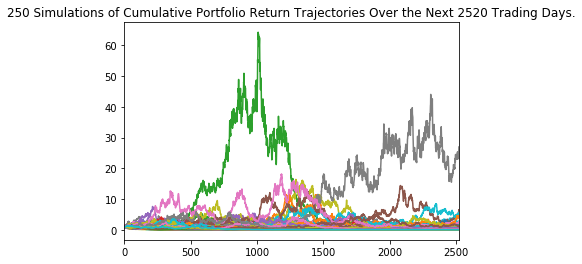

In [9]:
# Create Plot Simulation
line_plot = MC.plot_simulation();

# Save Plot Simulation
line_plot.figure.savefig(f"Images/MC_plot_simulation.png", bbox_inches='tight')

### Before moving on: Is a high volatile or low volatile outcome more likely?
 
### This graph represents the distribution of returns across all the simulations.

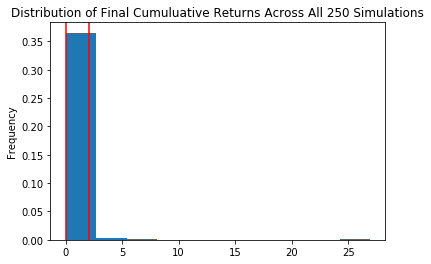

In [10]:
# Create Plot Distribution
plot_dist = MC.plot_distribution();

# Save Plot Distribution
plot_dist.figure.savefig(f"Images/MC_plot_distribution.png", bbox_inches='tight')

### This graph shows a low volatile outcome is more likely.

In [11]:
# Create Cumulative Return Table
tbl = MC.summarize_cumulative_return()

# Select Initial Investment
initial_investment = int(input("Input the amount of money you'd like to forecast in this analysis: $"))

# Set Lower Confidence Interval
ci_lower = round(tbl[8]*initial_investment,2)

# Set Upper Confidence Interval
ci_upper = round(tbl[9]*initial_investment,2)

# Print Results
print(f"""

There is a 95% chance that an initial investment of ${initial_investment} in the portfolio
over the next {num_years} years will end within in the range of ${ci_lower} and ${ci_upper}""")

Input the amount of money you'd like to forecast in this analysis: $ 1000




There is a 95% chance that an initial investment of $1000 in the portfolio
over the next 10 years will end within in the range of $0.16 and $2101.93


### These projections are based on the lower and upper confidence intervals.

# Rolling Statistics

## Definition: Looking at rolling statistics gives performance results that are smoothed over defined periods throughout its history. 

## Purpose: To create a more accurate picture than a single snapshot of one period.

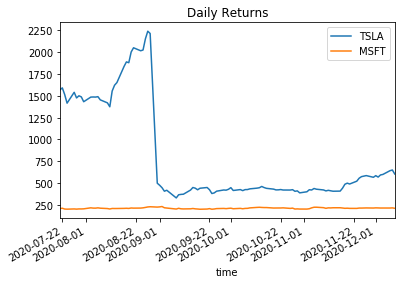

In [12]:
# Rolling Statistics vs Regular Statistics

dailyreturnsplot = portfolio_close.plot(title='Daily Returns');

dailyreturnsplot.figure.savefig(f"Images/dailyreturnsplot.png", bbox_inches='tight')

## A graph of daily returns can be volitile, make it difficult to determine overall trends.  Based on this graph, what stocks do you think are increasing overall?  Decreasing?

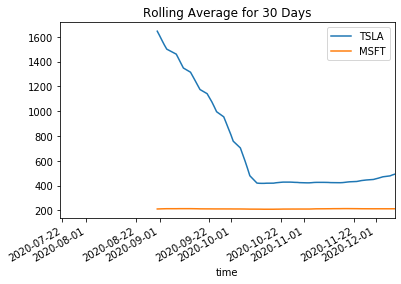

In [13]:
# Rolling Statistics - AVG

# Takes out daily variablitity

rollingmean = portfolio_close.rolling(window=30).mean()

rollingmeanplot = rollingmean.plot(title='Rolling Average for 30 Days');

rollingmeanplot.figure.savefig(f"Images/rollingmeansplot.png", bbox_inches='tight')

## Taking the 30 day rolling average smoothes the graphs and makes it easier to see overall trends. Based on the rolling average, would you change your previous answers?

## The Standard Deviation (STD) is a measure of the volitility of a stock.  It can be calculated as a single statistic for an entire dataset.  The higher the STD, the more volitile a stock.

In [14]:
# Calculate STD
overallstd = portfolio_close.std().sort_values()

overallstd

MSFT      6.711246
TSLA    583.062599
dtype: float64

## Based on this statistic, what can you say about the volitility of your stocks?

## The Rolling STD looks at changes in volitility over time.

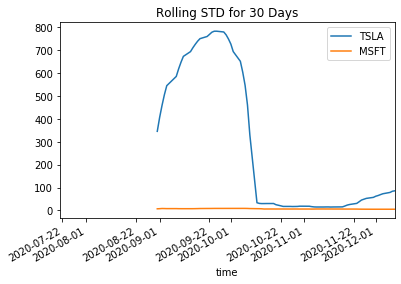

In [15]:
# Rolling STD for 30 days

rollingstd = portfolio_close.rolling(window=30).std()

rollingstdplot = rollingstd.plot(title='Rolling STD for 30 Days');

rollingstdplot.figure.savefig(f"Images/rollingstdplot.png", bbox_inches='tight')

## Based on this plot, how would you describe the volitility of your stocks?  Are some more volitle than others?  Do they have periods of higher and lower volitility?  What could influence these?